## 1. Introduction / Business Problem

Moving to a new city can be puzzling. All areas look the same and deciding where to establish your nest is a tricky process.

The aim of this recommendation system is ranking the districts of Berlin (Germany) based on the importance attributed to the following criteria:

1. **Green Spaces** (number and dimension of parks within the neighborhood)
2. **Kindergarden** (number of kindergardens in the area)
3. **Nightlife** (number of clubs and bars in the area)
4. **Eating Out** (number and variety of restaurants)
5. **Quality Yoga** (availability and average rating of yoga schools)

The six districts we are going to consider in the recommendation system are: Mitte, Pankow, Charlottenburg-Wilmersdorf, Tempelhof-Schöneberg, Neukölln and Friedrichshain-Kreuzberg

In [2]:
import pandas as pd
import numpy as np
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

We asked five apartment seekers to weigh each criteria based on a scale from 0 to 4

In [3]:
recom_subjects = pd.read_csv('Subjects - Sheet1.csv', engine="python")
recom_subjects

,Name,Green Space,Kindergarden,Nightlife,Eating Out,Quality Yoga
0,Brenda,0,2,4,2,1
1,Dylan,0,0,3,4,3
2,Kelly,3,0,4,2,2
3,Andrea,1,2,0,3,4
4,Steve,4,2,3,2,3


The desired outcome of the recommendation system is a ranking of the districts that is tailored on the weights specified by each individual apartment seeker

Eg. "The best districts for Brenda are 1. Neukoelln 2. Schoeneberg 3. Pankow 4. Mitte 5. Kreuzberg 6. Charlottenburg"

In order to do that, we will first score each district for the different criteria then multiply the scores by the personal weights provided by the apartment seekers.

## 2. Collecting and Cleaning Data

First, let's import in a dataframe some information related to the districts of Berlin. Data taken from Wikipedia

In [3]:
df1 = pd.read_csv('BerlinDistricts (1).csv', engine="python")

In [4]:
df1.head()

,Nr.,Bezirk,Ortsteile,FlÃ¤chein kmÂ²,Einwohner[2](30.Â JuniÂ 2019),Einwohnerpro kmÂ²(30.Â JuniÂ 2019),BezirksÂ­bÃ¼rgerÂ­meister[3],Karte
0,1,Mitte,0101 Mitte0102 Moabit0103 Hansaviertel0104 Tie...,39.47,384.172,9.733,Stephan von Dassel (GrÃ¼ne),Lage
1,2,Friedrichshain-Kreuzberg,0201 Friedrichshain0202 Kreuzberg,20.16,289.762,14.373,Monika Herrmann (GrÃ¼ne),Lage
2,3,Pankow,0301 Prenzlauer Berg0302 WeiÃŸensee0303 Blanke...,103.01,407.765,3.958,SÃ¶ren Benn (Die Linke),Lage
3,4,Charlottenburg-Wilmersdorf,0401 Charlottenburg0402 Wilmersdorf0403 Schmar...,64.72,342.332,5.289,Reinhard Naumann (SPD),Lage
4,5,Spandau,0501 Spandau0502 Haselhorst0503 Siemensstadt05...,91.91,243.977,2.655,Helmut Kleebank (SPD),Lage


Let's export only the information we need and in the metrics we need

In [5]:
DistrictInfo = pd.DataFrame(columns=["District","Dimension (square meters)"])
DistrictInfo["District"] = df1["Bezirk"]
DistrictInfo["Dimension (square meters)"] = df1["FlÃ¤chein kmÂ²"]*1000000

In [6]:
DistrictInfo.drop(5, inplace=True)
DistrictInfo.drop(8, inplace=True)
DistrictInfo.drop(9, inplace=True)
DistrictInfo.drop(10, inplace=True)
DistrictInfo.drop(11, inplace=True)

In [7]:
DistrictInfo

,District,Dimension (square meters)
0,Mitte,39470000.0
1,Friedrichshain-Kreuzberg,20160000.0
2,Pankow,103010000.0
3,Charlottenburg-Wilmersdorf,64720000.0
4,Spandau,91910000.0
6,Tempelhof-Schöneberg,53090000.0
7,Neukölln,44930000.0


Now, let's create a dataframe where we'll store each district's score in regard of the five criteria

In [8]:
DistrictScores = pd.DataFrame(columns=["District"])
DistrictScores["District"] = DistrictInfo["District"]

In [9]:
DistrictScores

,District
0,Mitte
1,Friedrichshain-Kreuzberg
2,Pankow
3,Charlottenburg-Wilmersdorf
4,Spandau
6,Tempelhof-Schöneberg
7,Neukölln


Let's import the Zip Codes for each district, which will come into play later

In [10]:
DistrictZipAndGeo = pd.read_csv('ZipAndGeo.csv',engine="python")

In [11]:
DistrictZipAndGeo.head()

,Zip Code,Place,Latitude,Longitude,Unnamed: 4,Unnamed: 5
0,10115,Mitte,52.516745,13.366796,NaN,NaN
1,10117,Mitte,52.516745,13.366796,NaN,NaN
2,10119,Mitte,52.516745,13.366796,NaN,NaN
3,10178,Mitte,52.516745,13.366796,NaN,NaN
4,10179,Mitte,52.516745,13.366796,NaN,NaN


Let's format the dataframe in a more comprehensible way

In [12]:
DistrictZipAndGeo = DistrictZipAndGeo.rename(columns={'Place': 'District'})
DistrictZipAndGeo.drop("Unnamed: 4", axis=1, inplace=True)
DistrictZipAndGeo.drop("Unnamed: 5", axis=1, inplace=True)

In [13]:
DistrictZipAndGeo.head()

,Zip Code,District,Latitude,Longitude
0,10115,Mitte,52.516745,13.366796
1,10117,Mitte,52.516745,13.366796
2,10119,Mitte,52.516745,13.366796
3,10178,Mitte,52.516745,13.366796
4,10179,Mitte,52.516745,13.366796


Since the original Zip Codes aren't specific enough, I'm going to erase their values and retrieve the correct ones from the internet

In [14]:
DistrictZipAndGeo["Latitude"]=np.nan
DistrictZipAndGeo["Longitude"]=np.nan

In [15]:
for index, row in DistrictZipAndGeo.iterrows():
    url = 'http://api.zippopotam.us/de/'+str(row["Zip Code"])
    results = requests.get(url).json()
    DistrictZipAndGeo.at[index,'Latitude'] = results["places"][0]["latitude"]
    DistrictZipAndGeo.at[index,'Longitude'] = results["places"][0]["longitude"]

In [18]:
DistrictZipAndGeo.head()

,Zip Code,District,Latitude,Longitude
0,10115,Mitte,52.532000,13.39220
1,10117,Mitte,52.516100,13.38740
2,10119,Mitte,52.528500,13.41090
3,10178,Mitte,52.522179,13.40651
4,10179,Mitte,52.513600,13.42320


## 3. Scoring Each Criteria

### 3.1 Kindergarden

In [19]:
import matplotlib.pyplot as plt

The Kindergarden scoring is based on the idea that the more kindergardens per postal area your district has, the higher the chances to find and be admitted to the perfect one.

Let's set up our Foursquare credentials

In [20]:
CLIENT_ID = 'WFBOAZ2MLLQ4FAZZ3DE1OUC22KXFT5HIIRTMVGQUBURBUB1Y' # your Foursquare ID
CLIENT_SECRET = 'KZTBP4BY120ID4MBNCONB1RCA0L3XKZJQUQCXW5SG3UUFZBK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius


print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WFBOAZ2MLLQ4FAZZ3DE1OUC22KXFT5HIIRTMVGQUBURBUB1Y
CLIENT_SECRET:KZTBP4BY120ID4MBNCONB1RCA0L3XKZJQUQCXW5SG3UUFZBK


In [4]:
CATEGORY = '5744ccdfe4b0c0459246b4c7' #venue category we want to retrieve == Day Care for Children

Let's define the function that will retrieve the information about Day Care Children structures in the different areas

In [21]:
def getVenues(postalcodes, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for postalcode, lat, lng in zip(postalcodes, latitudes, longitudes):
        print(postalcode)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            CATEGORY)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postalcode, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                    'PostalCode Latitude', 
                    'PostalCode Longitude',
                    'Venue ID',
                    'Venue', 
                    'Venue Latitude', 
                    'Venue Longitude', 
                    'Venue Category']
    
    return(nearby_venues)

In [ ]:
selected_venues = getVenues(postalcodes=DistrictZipAndGeo['Zip Code'],
                                   latitudes=DistrictZipAndGeo['Latitude'],
                                   longitudes=DistrictZipAndGeo['Longitude']
                                  )

In [47]:
selected_venues.head()

,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10115,52.5320,13.3922,4d957490e07ea35d35eaa702,Kita Gartenstrasse,52.528883,13.390804,Daycare
1,10117,52.5161,13.3874,527695ad11d230800ba78e7b,Kita Alegria,52.511899,13.387390,Daycare
2,10119,52.5285,13.4109,52316c4d11d22aef2654347f,Kita Fridolin,52.526849,13.409277,Daycare
3,10119,52.5285,13.4109,5315e67e498e9b40a2dbda38,Kita Herz Jesu,52.530354,13.409853,Daycare
4,10119,52.5285,13.4109,4d3da04e14aa8cfad642b55e,Kita Pfiffikus,52.527665,13.407310,Daycare


In [52]:
selected_venues.rename(columns={"PostalCode":"Zip Code"}, inplace=True)

In [53]:
selected_venues.head()

,Zip Code,PostalCode Latitude,PostalCode Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10115,52.5320,13.3922,4d957490e07ea35d35eaa702,Kita Gartenstrasse,52.528883,13.390804,Daycare
1,10117,52.5161,13.3874,527695ad11d230800ba78e7b,Kita Alegria,52.511899,13.387390,Daycare
2,10119,52.5285,13.4109,52316c4d11d22aef2654347f,Kita Fridolin,52.526849,13.409277,Daycare
3,10119,52.5285,13.4109,5315e67e498e9b40a2dbda38,Kita Herz Jesu,52.530354,13.409853,Daycare
4,10119,52.5285,13.4109,4d3da04e14aa8cfad642b55e,Kita Pfiffikus,52.527665,13.407310,Daycare


In [56]:
df = pd.merge(selected_venues,DistrictZipAndGeo[['Zip Code','District']],on='Zip Code', how='left')

In [60]:
KinderScores = df.groupby('District').count()[['Zip Code']]
KinderScores.rename(columns={"Zip Code":"Total Kindergardens"}, inplace=True)

Assuming that each postal area is similarly populated, it makes sense to calculate the score as the number of kindergardens per postal areas of each district and then normalize the value.

In [61]:
KinderScores

,Total Kindergardens
District,
Charlottenburg-Wilmersdorf,23
Friedrichshain-Kreuzberg,39
Mitte,27
Neukölln,9
Pankow,52
Tempelhof-Schöneberg,16


In [63]:
KinderScores["Zip Codes per District"] = DistrictZipAndGeo.groupby('District').count()[['Zip Code']].values

In [65]:
KinderScores["KGs per Zip Areas"] = KinderScores["Total Kindergardens"] / KinderScores["Zip Codes per District"]

In [66]:
KinderScores

,Total Kindergardens,Zip Codes per District,KGs per Zip Areas
District,,,
Charlottenburg-Wilmersdorf,23,25,0.920000
Friedrichshain-Kreuzberg,39,11,3.545455
Mitte,27,21,1.285714
Neukölln,9,9,1.000000
Pankow,52,21,2.476190
Tempelhof-Schöneberg,16,25,0.640000


In [ ]:
KinderScores["Score"] = KinderScores["KGs per Zip Areas"] / KinderScores["KGs per Zip Areas"].max()

In [70]:
KinderScores

,Total Kindergardens,Zip Codes per District,KGs per Zip Areas,Score
District,,,,
Charlottenburg-Wilmersdorf,23,25,0.920000,0.259487
Friedrichshain-Kreuzberg,39,11,3.545455,1.000000
Mitte,27,21,1.285714,0.362637
Neukölln,9,9,1.000000,0.282051
Pankow,52,21,2.476190,0.698413
Tempelhof-Schöneberg,16,25,0.640000,0.180513


Let's add this section's scores to the dataframe containing all the scores

In [71]:
DistrictScores["Kindergarden"] = np.nan

In [72]:
DistrictScores["District"].unique()

array(['Mitte', 'Friedrichshain-Kreuzberg', 'Pankow',
       'Charlottenburg-Wilmersdorf', 'Tempelhof-Schöneberg', 'Neukölln'],
      dtype=object)

In [75]:
for index, row in DistrictScores.iterrows():
    DistrictScores.at[index,"Kindergarden"] = KinderScores.loc[row["District"], "Score"]


In [76]:
DistrictScores

,District,Kindergarden
0,Mitte,0.362637
1,Friedrichshain-Kreuzberg,1.000000
2,Pankow,0.698413
3,Charlottenburg-Wilmersdorf,0.259487
6,Tempelhof-Schöneberg,0.180513
7,Neukölln,0.282051


### 3.2 Green Spaces

The Green Space scoring is based on how much green space a district has compared to its total surface (total green surface / total district surface)

In order to calculate this, we need a list of all Berlin parks, their dimension and the district they belong to. The data was taken from Wikipedia

In [23]:
df = pd.read_csv('BerlinParks (2).csv', engine="python")

In [24]:
df.head()

,Name/Lage,Bezirk,Ortsteil,GrÃ¶ÃŸe inÂ ha,Datierung(angelegt / erÃ¶ffnet),"Anmerkungen, Fotos"
0,Lietzenseepark[1](Lage),Charlottenburg-Wilmersdorf,Charlottenburg,10.0,abÂ 1899,Gartendenkmal
1,Margarete-und-Arthur-Eloesser-Park[2] (Lage),Charlottenburg-Wilmersdorf,Charlottenburg,0.5,2008,NaN
2,Mierendorffplatz (Lage),Charlottenburg-Wilmersdorf,Charlottenburg,0.9,1912â€“1913,"Umbau 1950â€“1951, 1979; Entwurf von Erwin Bar..."
3,Ã–sterreichpark (Lage),Charlottenburg-Wilmersdorf,Charlottenburg,0.3,2013,NaN
4,Savignyplatz (Lage),Charlottenburg-Wilmersdorf,Charlottenburg,0.5,1892,"Neugestaltung 1926 durch Erwin Barth, Restauri..."


Let's clean and organize the data

In [25]:
df.columns = ["Park Name","District","Neighborhood","Dimension","Date","Photos"]

In [26]:
missing_data = df.isnull()

In [27]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

Park Name
False    210
Name: Park Name, dtype: int64

District
False    210
Name: District, dtype: int64

Neighborhood
False    210
Name: Neighborhood, dtype: int64

Dimension
False    184
True      26
Name: Dimension, dtype: int64

Date
False    151
True      59
Name: Date, dtype: int64

Photos
True     135
False     75
Name: Photos, dtype: int64



I'm going to get rid of unnecessary columns and replace all NaN park dimensions with the median value of the column. I will also convert the measure unit from hectars to square meters.

In [28]:
median = df["Dimension"].median()
df["Dimension"].replace(np.nan, median, inplace = True)

In [29]:
df.drop("Date", axis=1, inplace = True)
df.drop("Neighborhood", axis=1, inplace= True)
df.drop("Photos", axis =1, inplace = True)
df["Dimension"] = df["Dimension"] * 10000 #a square meter equals 10000 hectars

In [30]:
df.head()

,Park Name,District,Dimension
0,Lietzenseepark[1](Lage),Charlottenburg-Wilmersdorf,100000.0
1,Margarete-und-Arthur-Eloesser-Park[2] (Lage),Charlottenburg-Wilmersdorf,5000.0
2,Mierendorffplatz (Lage),Charlottenburg-Wilmersdorf,9000.0
3,Ã–sterreichpark (Lage),Charlottenburg-Wilmersdorf,3000.0
4,Savignyplatz (Lage),Charlottenburg-Wilmersdorf,5000.0


Let's calculate the total green area for each district then add a column with the total surface of each district.

In [40]:
GreenScore = df.groupby(['District'])[['Dimension']].agg('sum')
GreenScore.rename(columns={"Dimension":"Green Surface (square meters)"}, inplace=True)
GreenScore.drop("Lichtenberg", inplace=True)
GreenScore.drop("Marzahn-Hellersdorf", inplace=True)
GreenScore.drop("Reinickendorf",inplace=True)
GreenScore.drop("Spandau",inplace=True)
GreenScore.drop("Steglitz-Zehlendorf", inplace=True)
GreenScore.drop("Treptow-Köpenick", inplace=True)


In [41]:
GreenScore

,Green Surface (square meters)
District,
Charlottenburg-Wilmersdorf,3063000.0
Friedrichshain-Kreuzberg,1209000.0
Mitte,5285000.0
Neukölln,2354000.0
Pankow,2203000.0
Tempelhof-Schöneberg,4060000.0


In [42]:
GreenScore["Total Surface"] = np.nan

In [43]:
for index, row in DistrictInfo.iterrows():
    GreenScore.at[row["District"],"Total Surface"] = row["Dimension (square meters)"]

In [47]:
GreenScore.drop("Spandau",inplace=True)

In [48]:

GreenScore["GreenRatio"] = GreenScore["Green Surface (square meters)"] / GreenScore["Total Surface"]

In [49]:
GreenScore

,Green Surface (square meters),Total Surface,GreenRatio
District,,,
Charlottenburg-Wilmersdorf,3063000.0,64720000.0,0.047327
Friedrichshain-Kreuzberg,1209000.0,20160000.0,0.059970
Mitte,5285000.0,39470000.0,0.133899
Neukölln,2354000.0,44930000.0,0.052393
Pankow,2203000.0,103010000.0,0.021386
Tempelhof-Schöneberg,4060000.0,53090000.0,0.076474


The score for this criterium will now be a normalized version of the Green Ratio for each district

In [50]:
GreenScore["Score"] = GreenScore["GreenRatio"] / GreenScore["GreenRatio"].max()

In [51]:
GreenScore

,Green Surface (square meters),Total Surface,GreenRatio,Score
District,,,,
Charlottenburg-Wilmersdorf,3063000.0,64720000.0,0.047327,0.353452
Friedrichshain-Kreuzberg,1209000.0,20160000.0,0.059970,0.447876
Mitte,5285000.0,39470000.0,0.133899,1.000000
Neukölln,2354000.0,44930000.0,0.052393,0.391284
Pankow,2203000.0,103010000.0,0.021386,0.159719
Tempelhof-Schöneberg,4060000.0,53090000.0,0.076474,0.571131


Let's add the score to the main dataframe with all criteria

In [52]:
DistrictScores["Green Space"] = np.nan

In [56]:
for index, row in DistrictScores.iterrows():
    DistrictScores.at[index,"Green Space"] = GreenScore.loc[row["District"], "Score"]

In [57]:
DistrictScores

,District,Kindergarden,Green Space
0,Mitte,0.362637,1.000000
1,Friedrichshain-Kreuzberg,1.000000,0.447876
2,Pankow,0.698413,0.159719
3,Charlottenburg-Wilmersdorf,0.259487,0.353452
4,Tempelhof-Schöneberg,0.180513,0.571131
5,Neukölln,0.282051,0.391284


### 3.3 Eating Out

The Eating Out scoring is based on the variety of cuisine within the whole district

I'll use the credentials previously specified to retrieve restaurant information from Foursquare, but I need to specify the correct venue category ("restaurants")

In [58]:
CATEGORY = '4d4b7105d754a06374d81259' #Venue Category ID for restaurants

In [ ]:
selected_venues = getVenues(postalcodes=DistrictZipAndGeo['Zip Code'],
                                   latitudes=DistrictZipAndGeo['Latitude'],
                                   longitudes=DistrictZipAndGeo['Longitude']
                                  )

In [61]:
selected_venues.head()

,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10115,52.532,13.3922,4f10979be4b0958ec0480efa,Katz Orange,52.531517,13.395215,Restaurant
1,10115,52.532,13.3922,4af1e1b6f964a52011e421e3,Papà Pane di Sorrento,52.532088,13.396228,Italian Restaurant
2,10115,52.532,13.3922,51dee058498e7993b416a779,Vom Einfachen das Gute,52.532432,13.396565,Deli / Bodega
3,10115,52.532,13.3922,56ad2378498e4972b9acae41,Alpenstueck Bäckerei,52.530105,13.392126,Bakery
4,10115,52.532,13.3922,563e12fbcd10258c12dcf45c,Simply Keto,52.532187,13.396141,Café


Let's clean the data and add a column with the district corresponding to each Zip Code

In [64]:
selected_venues.rename(columns={"PostalCode" : "Zip Code"}, inplace = True)
df = pd.merge(selected_venues,DistrictZipAndGeo[['Zip Code','District']],on='Zip Code', how='left')
df.head()

,Zip Code,PostalCode Latitude,PostalCode Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,District
0,10115,52.532,13.3922,4f10979be4b0958ec0480efa,Katz Orange,52.531517,13.395215,Restaurant,Mitte
1,10115,52.532,13.3922,4af1e1b6f964a52011e421e3,Papà Pane di Sorrento,52.532088,13.396228,Italian Restaurant,Mitte
2,10115,52.532,13.3922,51dee058498e7993b416a779,Vom Einfachen das Gute,52.532432,13.396565,Deli / Bodega,Mitte
3,10115,52.532,13.3922,56ad2378498e4972b9acae41,Alpenstueck Bäckerei,52.530105,13.392126,Bakery,Mitte
4,10115,52.532,13.3922,563e12fbcd10258c12dcf45c,Simply Keto,52.532187,13.396141,Café,Mitte


Since each "Venue Category" specifies a different kind of restaurant, in order to assess the variety of food present in each district we can start by counting how many unique value the column has for every district

In [65]:
dfcount = df.groupby('District')['Venue Category'].nunique() #first I group by district, then calculate number of unique values
dfcount

District
Charlottenburg-Wilmersdorf    68
Friedrichshain-Kreuzberg      74
Mitte                         75
Neukölln                      50
Pankow                        64
Tempelhof-Schöneberg          65
Name: Venue Category, dtype: int64

In [66]:
EatingScore = pd.DataFrame(index=dfcount.index)

In [68]:
EatingScore["Unique Food Types"] =dfcount.values
EatingScore

,Unique Food Types
District,
Charlottenburg-Wilmersdorf,68
Friedrichshain-Kreuzberg,74
Mitte,75
Neukölln,50
Pankow,64
Tempelhof-Schöneberg,65


The score for this criterium will be a normalize version of the number of Unique Food Types one can eat within the whole district

In [69]:
EatingScore["Score"] = EatingScore["Unique Food Types"] / EatingScore["Unique Food Types"].max()
EatingScore

,Unique Food Types,Score
District,,
Charlottenburg-Wilmersdorf,68,0.906667
Friedrichshain-Kreuzberg,74,0.986667
Mitte,75,1.000000
Neukölln,50,0.666667
Pankow,64,0.853333
Tempelhof-Schöneberg,65,0.866667


Let's add the score to the main dataframe with all criteria

In [70]:
DistrictScores["Eating Out"] = np.nan

In [71]:
for index, row in DistrictScores.iterrows():
    DistrictScores.at[index,"Eating Out"] = EatingScore.loc[row["District"], "Score"]

In [72]:
DistrictScores

,District,Kindergarden,Green Space,Eating Out
0,Mitte,0.362637,1.000000,1.000000
1,Friedrichshain-Kreuzberg,1.000000,0.447876,0.986667
2,Pankow,0.698413,0.159719,0.853333
3,Charlottenburg-Wilmersdorf,0.259487,0.353452,0.906667
4,Tempelhof-Schöneberg,0.180513,0.571131,0.866667
5,Neukölln,0.282051,0.391284,0.666667


### 3.4 Quality Yoga

The scoring for Quality Yoga is based on the average rating of the yoga studios in each district

In [24]:
CATEGORY = '4bf58dd8d48988d102941735' #category id for Yoga Studios

In [ ]:
selected_venues = getVenues(postalcodes=DistrictZipAndGeo['Zip Code'],
                                   latitudes=DistrictZipAndGeo['Latitude'],
                                   longitudes=DistrictZipAndGeo['Longitude']
                                  )

In [26]:
selected_venues.head()

,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10115,52.532000,13.39220,5dc45c570c311500087ac412,Y4all - Yoga & Fitness,52.531480,13.398550,Yoga Studio
1,10115,52.532000,13.39220,4c9bfd8e9975a143a2802ecf,Nadja & Zachs,52.528171,13.391982,Yoga Studio
2,10115,52.532000,13.39220,4e5641ce814d5c451307bf11,Ashtanga Yoga Berlin,52.531315,13.398612,Yoga Studio
3,10119,52.528500,13.41090,5464f80c498eb4de1090ccbb,Yoga Welt,52.526671,13.407915,Yoga Studio
4,10178,52.522179,13.40651,50ec3e89e4b0c0cf862c5809,Yogatribe,52.524093,13.405199,Yoga Studio


Let's define a function that will retrieve the average rating for each Yoga Studio

In [27]:
def getYogaRatings(venueids):
    
    venues_ratings=[]
    for venueid in venueids:
        print(venueid)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/'+str(venueid)+'?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION)
        
            
        # make the GET request
        results = requests.get(url).json()["response"]["venue"]
        
        
        
        # return only relevant information for each nearby venue
       

        try:
            rating = results["rating"]
                
        except:
            rating = np.nan
            
        venues_ratings.append([results['id'], rating])    
      

    final_ratings = pd.DataFrame(venues_ratings, columns=["Venue Id","Venue Rating"])
    
    
    return(final_ratings)

In [ ]:
yogaRatings = getYogaRatings(selected_venues["Venue ID"])

In [38]:
yogaRatings

,Venue Id,Venue Rating
0,5dc45c570c311500087ac412,8.270844
1,4c9bfd8e9975a143a2802ecf,6.815320
2,4e5641ce814d5c451307bf11,5.298014
3,5464f80c498eb4de1090ccbb,9.294120
4,50ec3e89e4b0c0cf862c5809,8.100000
5,4b13f64ff964a520fd9a23e3,7.700000
6,4b7c0a1af964a520ca792fe3,8.400000
7,5a5e092195da0c2e206a684e,7.562295
8,57618c1d498e6e9cd08f1166,6.465230
9,5c89415a1ffe97002c0188a8,5.183137


In [39]:
yogaRatings.index = yogaRatings["Venue Id"]

In [40]:
yogaRatings

,Venue Id,Venue Rating
Venue Id,,
5dc45c570c311500087ac412,5dc45c570c311500087ac412,8.270844
4c9bfd8e9975a143a2802ecf,4c9bfd8e9975a143a2802ecf,6.815320
4e5641ce814d5c451307bf11,4e5641ce814d5c451307bf11,5.298014
5464f80c498eb4de1090ccbb,5464f80c498eb4de1090ccbb,9.294120
50ec3e89e4b0c0cf862c5809,50ec3e89e4b0c0cf862c5809,8.100000
4b13f64ff964a520fd9a23e3,4b13f64ff964a520fd9a23e3,7.700000
4b7c0a1af964a520ca792fe3,4b7c0a1af964a520ca792fe3,8.400000
5a5e092195da0c2e206a684e,5a5e092195da0c2e206a684e,7.562295
57618c1d498e6e9cd08f1166,57618c1d498e6e9cd08f1166,6.465230


In [44]:
selected_venues["Venue rating"] = np.nan;

In [45]:
selected_venues.head()

,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue rating
0,10115,52.532000,13.39220,5dc45c570c311500087ac412,Y4all - Yoga & Fitness,52.531480,13.398550,Yoga Studio,NaN
1,10115,52.532000,13.39220,4c9bfd8e9975a143a2802ecf,Nadja & Zachs,52.528171,13.391982,Yoga Studio,NaN
2,10115,52.532000,13.39220,4e5641ce814d5c451307bf11,Ashtanga Yoga Berlin,52.531315,13.398612,Yoga Studio,NaN
3,10119,52.528500,13.41090,5464f80c498eb4de1090ccbb,Yoga Welt,52.526671,13.407915,Yoga Studio,NaN
4,10178,52.522179,13.40651,50ec3e89e4b0c0cf862c5809,Yogatribe,52.524093,13.405199,Yoga Studio,NaN


In [64]:
for index, row in selected_venues.iterrows():
    selected_venues.at[index,"Venue rating"] = yogaRatings.loc[row["Venue ID"], "Venue Rating"]

In [65]:
selected_venues.head()

,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue rating
0,10115,52.532000,13.39220,5dc45c570c311500087ac412,Y4all - Yoga & Fitness,52.531480,13.398550,Yoga Studio,8.270844
1,10115,52.532000,13.39220,4c9bfd8e9975a143a2802ecf,Nadja & Zachs,52.528171,13.391982,Yoga Studio,6.815320
2,10115,52.532000,13.39220,4e5641ce814d5c451307bf11,Ashtanga Yoga Berlin,52.531315,13.398612,Yoga Studio,5.298014
3,10119,52.528500,13.41090,5464f80c498eb4de1090ccbb,Yoga Welt,52.526671,13.407915,Yoga Studio,6.574633
4,10178,52.522179,13.40651,50ec3e89e4b0c0cf862c5809,Yogatribe,52.524093,13.405199,Yoga Studio,8.100000


In [66]:
selected_venues.rename(columns={"PostalCode" : "Zip Code"}, inplace = True)
df = pd.merge(selected_venues,DistrictZipAndGeo[['Zip Code','District']],on='Zip Code', how='left')
df.head()

,Zip Code,PostalCode Latitude,PostalCode Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue rating,District
0,10115,52.5320,13.3922,5dc45c570c311500087ac412,Y4all - Yoga & Fitness,52.531480,13.398550,Yoga Studio,8.270844,Mitte
1,10115,52.5320,13.3922,4c9bfd8e9975a143a2802ecf,Nadja & Zachs,52.528171,13.391982,Yoga Studio,6.815320,Mitte
2,10115,52.5320,13.3922,4e5641ce814d5c451307bf11,Ashtanga Yoga Berlin,52.531315,13.398612,Yoga Studio,5.298014,Mitte
3,10119,52.5285,13.4109,5464f80c498eb4de1090ccbb,Yoga Welt,52.526671,13.407915,Yoga Studio,6.574633,Mitte
4,10119,52.5285,13.4109,5464f80c498eb4de1090ccbb,Yoga Welt,52.526671,13.407915,Yoga Studio,6.574633,Pankow


We now need the average of column Venue Rating grouped by the column District

In [69]:
dfaverage = df.groupby('District')['Venue rating'].mean()
dfaverage

District
Charlottenburg-Wilmersdorf    7.938380
Friedrichshain-Kreuzberg      7.609379
Mitte                         7.280710
Neukölln                      6.824877
Pankow                        8.194178
Tempelhof-Schöneberg          6.962079
Name: Venue rating, dtype: float64

In [70]:
YogaScore = pd.DataFrame(index=dfaverage.index)
YogaScore["Average Rating"] =dfaverage.values
YogaScore

,Average Rating
District,
Charlottenburg-Wilmersdorf,7.938380
Friedrichshain-Kreuzberg,7.609379
Mitte,7.280710
Neukölln,6.824877
Pankow,8.194178
Tempelhof-Schöneberg,6.962079


The score for this criterium will be a normalized version of the average rating for each district

In [71]:
YogaScore["Score"] = YogaScore["Average Rating"] / YogaScore["Average Rating"].max() 

In [72]:
YogaScore

,Average Rating,Score
District,,
Charlottenburg-Wilmersdorf,7.938380,0.968783
Friedrichshain-Kreuzberg,7.609379,0.928632
Mitte,7.280710,0.888522
Neukölln,6.824877,0.832893
Pankow,8.194178,1.000000
Tempelhof-Schöneberg,6.962079,0.849637


Let's add the Quality Yoga sore to the main dataframe for all criteria

In [73]:
DistrictScores["Quality Yoga"] = np.nan

for index, row in DistrictScores.iterrows():
    DistrictScores.at[index,"Quality Yoga"] = YogaScore.loc[row["District"], "Score"]

In [75]:
DistrictScores

,District,Kindergarden,Green Space,Eating Out,Quality Yoga
0,Mitte,0.362637,1.000000,1.000000,0.888522
1,Friedrichshain-Kreuzberg,1.000000,0.447876,0.986667,0.928632
2,Pankow,0.698413,0.159719,0.853333,1.000000
3,Charlottenburg-Wilmersdorf,0.259487,0.353452,0.906667,0.968783
4,Tempelhof-Schöneberg,0.180513,0.571131,0.866667,0.849637
5,Neukölln,0.282051,0.391284,0.666667,0.832893


### 3.5 Nightlife

The Nightlife scoring is based on the idea that the more bars/clubs you have in your postal area the better, but not in a linear proportional way.

In other words: having 10 bars compared to having 5 adds a lot more value than having 30 bars compared to having 20

We are going to describe this relationship through the following dataframe

In [ ]:
nightscoring = pd.DataFrame({"X":range(70)})
nightscoring

In [97]:
nightscoring["Y"] = 1-(2.72**(-0.2*nightscoring["X"]))

In [92]:
nightscoring

,X,Y
0,0,0.000000
1,1,0.259322
2,2,0.451396
3,3,0.593661
4,4,0.699034
5,5,0.777081
6,6,0.834889
7,7,0.877706
8,8,0.909420
9,9,0.932909


The relationship between the average number of bars/clubs in a District's postal area and the corresponding Nightlife score will look something like this 

In [100]:
import matplotlib.pyplot as plt

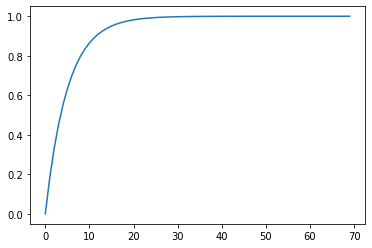

In [102]:
plt.plot(nightscoring["X"].values, nightscoring["Y"].values)

In [76]:
CATEGORY = '4d4b7105d754a06376d81259' #Category ID for night clubs and bars

In [ ]:
selected_venues = getVenues(postalcodes=DistrictZipAndGeo['Zip Code'],
                                   latitudes=DistrictZipAndGeo['Latitude'],
                                   longitudes=DistrictZipAndGeo['Longitude']
                                  )

In [78]:
selected_venues.head()

,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10115,52.532,13.3922,5092e44fe4b09d8b5d3c2397,Redwood,52.531670,13.394338,Cocktail Bar
1,10115,52.532,13.3922,56069b45498ee7b98431e3b3,BrewDog,52.532801,13.395789,Beer Bar
2,10115,52.532,13.3922,4d13b1be33ac3704aa7e9856,Krøhan Bress,52.531950,13.396177,Smoke Shop
3,10115,52.532,13.3922,5925dabffebf311e1940ceee,The Castle,52.531639,13.388372,Beer Bar
4,10115,52.532,13.3922,4d3b7e98979ea143328d9cfc,Buck & Breck,52.532108,13.399026,Cocktail Bar


In [83]:
selected_venues.rename(columns={"PostalCode":"Zip Code"}, inplace=True)

df = pd.merge(selected_venues,DistrictZipAndGeo[['Zip Code','District']],on='Zip Code', how='left')

In [84]:
df.head()

,Zip Code,PostalCode Latitude,PostalCode Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,District
0,10115,52.532,13.3922,5092e44fe4b09d8b5d3c2397,Redwood,52.531670,13.394338,Cocktail Bar,Mitte
1,10115,52.532,13.3922,56069b45498ee7b98431e3b3,BrewDog,52.532801,13.395789,Beer Bar,Mitte
2,10115,52.532,13.3922,4d13b1be33ac3704aa7e9856,Krøhan Bress,52.531950,13.396177,Smoke Shop,Mitte
3,10115,52.532,13.3922,5925dabffebf311e1940ceee,The Castle,52.531639,13.388372,Beer Bar,Mitte
4,10115,52.532,13.3922,4d3b7e98979ea143328d9cfc,Buck & Breck,52.532108,13.399026,Cocktail Bar,Mitte


In [85]:
NightScores = df.groupby('District').count()[['Zip Code']]
NightScores.rename(columns={"Zip Code":"Total Venues"}, inplace=True)
NightScores

,Total Venues
District,
Charlottenburg-Wilmersdorf,213
Friedrichshain-Kreuzberg,332
Mitte,350
Neukölln,136
Pankow,363
Tempelhof-Schöneberg,270


In [86]:
NightScores["Zip Codes per District"] = DistrictZipAndGeo.groupby('District').count()[['Zip Code']].values

In [87]:
NightScores

,Total Venues,Zip Codes per District
District,,
Charlottenburg-Wilmersdorf,213,25
Friedrichshain-Kreuzberg,332,11
Mitte,350,21
Neukölln,136,9
Pankow,363,21
Tempelhof-Schöneberg,270,25


In [88]:
NightScores["Venues per Zip Areas"] = NightScores["Total Venues"] / NightScores["Zip Codes per District"]

In [89]:
NightScores

,Total Venues,Zip Codes per District,Venues per Zip Areas
District,,,
Charlottenburg-Wilmersdorf,213,25,8.520000
Friedrichshain-Kreuzberg,332,11,30.181818
Mitte,350,21,16.666667
Neukölln,136,9,15.111111
Pankow,363,21,17.285714
Tempelhof-Schöneberg,270,25,10.800000


Now that we have the average number of bars/clubs per zip area for each district, we can retrieve the score based on the relationship previously described

In [93]:
NightScores["Score"] = np.nan

In [98]:
for index, row in NightScores.iterrows():
    NightScores.at[index, "Score"] = nightscoring.loc[round(row["Venues per Zip Areas"]), "Y"]

In [99]:
NightScores

,Total Venues,Zip Codes per District,Venues per Zip Areas,Score
District,,,,
Charlottenburg-Wilmersdorf,213,25,8.520000,0.834889
Friedrichshain-Kreuzberg,332,11,30.181818,0.997531
Mitte,350,21,16.666667,0.966698
Neukölln,136,9,15.111111,0.950307
Pankow,363,21,17.285714,0.966698
Tempelhof-Schöneberg,270,25,10.800000,0.889351


Let's add the Nightlife score to the main dataframe with all the criteria

In [103]:
DistrictScores["Nightlife"] = np.nan

for index, row in DistrictScores.iterrows():
    DistrictScores.at[index,"Nightlife"] = NightScores.loc[row["District"], "Score"]

In [104]:
DistrictScores

,District,Kindergarden,Green Space,Eating Out,Quality Yoga,Nightlife
0,Mitte,0.362637,1.000000,1.000000,0.888522,0.966698
1,Friedrichshain-Kreuzberg,1.000000,0.447876,0.986667,0.928632,0.997531
2,Pankow,0.698413,0.159719,0.853333,1.000000,0.966698
3,Charlottenburg-Wilmersdorf,0.259487,0.353452,0.906667,0.968783,0.834889
4,Tempelhof-Schöneberg,0.180513,0.571131,0.866667,0.849637,0.889351
5,Neukölln,0.282051,0.391284,0.666667,0.832893,0.950307


## 4. Recommending Districts (Results)

Let's review the weights that each apartment seeker assigned to the different criteria

In [6]:
recom_subjects

,Name,Green Space,Kindergarden,Nightlife,Eating Out,Quality Yoga
0,Brenda,0,2,4,2,1
1,Dylan,0,0,3,4,3
2,Kelly,3,0,4,2,2
3,Andrea,1,2,0,3,4
4,Steve,4,2,3,2,3


We have everything we need to rank the six districts based on each subject's preferences

In [11]:
for index, row in recom_subjects.iterrows():
    df = DistrictScores*1
    for criteria in recom_subjects.columns[1:]:
        df[criteria] = df[criteria]*row[criteria]
    df["Total"] = df.sum(axis=1)
    df1 = df.sort_values(by=['Total'], ascending=False)
    print('The Best Districts for '+row["Name"]+' from best to worst are: ')
    print(" ")
    print(df1["District"])
    print(" ")
    print(" ")
    print(" ")
    print(" ")

The Best Districts for Brenda from best to worst are: 
 
1      Friedrichshain-Kreuzberg
2                        Pankow
0                         Mitte
3    Charlottenburg-Wilmersdorf
5                      Neukölln
4          Tempelhof-Schöneberg
Name: District, dtype: object
 
 
 
 
The Best Districts for Dylan from best to worst are: 
 
1      Friedrichshain-Kreuzberg
0                         Mitte
2                        Pankow
3    Charlottenburg-Wilmersdorf
4          Tempelhof-Schöneberg
5                      Neukölln
Name: District, dtype: object
 
 
 
 
The Best Districts for Kelly from best to worst are: 
 
0                         Mitte
1      Friedrichshain-Kreuzberg
4          Tempelhof-Schöneberg
3    Charlottenburg-Wilmersdorf
2                        Pankow
5                      Neukölln
Name: District, dtype: object
 
 
 
 
The Best Districts for Andrea from best to worst are: 
 
1      Friedrichshain-Kreuzberg
0                         Mitte
2                   

## 5. Observations and Conclusions

Despite the heterogenous criteria, districts like Kreuzberg and Mitte seem to be across the board more desirable than - for example - Neukoelln. A result that in many ways reflects the actual reputation of different districts among Berliners and tourists alike.

Had I included the average cost of rent and life in the list of the criteria, Neukoelln would have probably been at least partly redeemed. Next time.

 